In [410]:
import pandas as pd
import requests
import pandas as pd
import requests
from datetime import datetime
import numpy as np
import collections

url='https://raw.githubusercontent.com/rather-be-hiking/stc510-public/main/crimestat.csv'
crimes=pd.read_csv(url, index_col='INC NUMBER')

url='https://raw.githubusercontent.com/rather-be-hiking/stc510-public/main/uszips.csv'
zips=pd.read_csv(url, index_col="zip")


In [411]:
crimes.rename(columns={"OCCURRED ON":"occured_on", \
                       "OCCURRED TO":"occured_to", \
                       "UCR CRIME CATEGORY":"crime_category", \
                       "100 BLOCK ADDR":"address", \
                       "ZIP":"zip_code", \
                       "PREMISE TYPE":"location_type"}, inplace=True)

In [502]:
# let's see where the high crme zip codes are
zip_crimes_list = crimes.zip_code.unique()
zip_crimes_list_t = []
for zip_entry in zip_crimes_list:
    if pd.isna(zip_entry)==False:
        zip_crimes_list_t.append(str(int(zip_entry)))

#print(zip_crimes_list_t)
        
zip_crimes = dict.fromkeys(zip_crimes_list_t,0)

for index, crime in crimes.iterrows():
    if pd.isna(crime['zip_code'])==False:
        key = str(int(crime['zip_code']))
        #zip_crimes[zip_item].append(crimes[(crimes.zip_code==zip_item)])
        zip_crimes[key]+=1

# order the zip codes by greatest crime volume to least
ordered_zip_crime_volume = sorted(zip_crimes.items(), key=lambda x:x[1], reverse=True)

#print(ordered_zip_crime_volume)

# show the top 10 zip codes by incdent count
for i in range(40):
    #print(ordered_zip_crime_volume[i][0])
    zip_int=int(ordered_zip_crime_volume[i][0])
    city=zips.loc[zip_int,'city'] + \
            ', '+zips.loc[zip_int,'state_id']
    crime_volume = ordered_zip_crime_volume[i][1]
    population = zips.loc[zip_int,'population']
    per_capita = crime_volume/population
    #print(city)
    print(str(ordered_zip_crime_volume[i][0]) +' '+ str(crime_volume) +' '+city +' '+ str(population) +' '+ str(per_capita))


#import matplotlib.pyplot as plt

#y = np.arange(len(ordered_zip_crime_volume))
#x = ordered_zip_crime_volume.values()
#plt.plot(x,y)
#plt.show()



85015 6963 Phoenix, AZ 41895.0 0.16620121732903687
85008 6320 Phoenix, AZ 62340.0 0.1013795316008983
85009 5513 Phoenix, AZ 51711.0 0.10661174605016341
85041 5477 Phoenix, AZ 62152.0 0.08812266700991118
85051 5389 Phoenix, AZ 45313.0 0.118928342859665
85017 5355 Phoenix, AZ 42656.0 0.12553919729932483
85035 4752 Phoenix, AZ 59660.0 0.07965135769359705
85043 4330 Phoenix, AZ 38704.0 0.11187474162877221
85032 4301 Phoenix, AZ 73203.0 0.0587544226329522
85033 4258 Phoenix, AZ 64832.0 0.06567744323790721
85021 4256 Phoenix, AZ 43378.0 0.0981142514638757
85029 4121 Phoenix, AZ 47080.0 0.08753186066270179
85023 3927 Phoenix, AZ 34268.0 0.11459670829928796
85016 3794 Phoenix, AZ 35930.0 0.10559421096576677
85040 3778 Phoenix, AZ 35204.0 0.10731735030110215
85042 3580 Phoenix, AZ 47957.0 0.07465020747753195
85022 3573 Phoenix, AZ 51920.0 0.06881741140215716
85019 3070 Phoenix, AZ 27813.0 0.11038003811167439
85037 3004 Phoenix, AZ 54817.0 0.05480051808745462
85031 2993 Phoenix, AZ 33886.0 0.088

<AxesSubplot:>

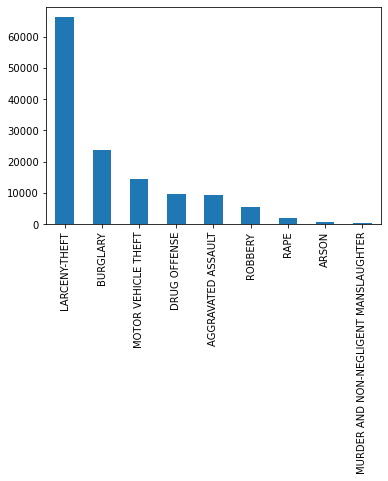

In [413]:
# case counts by crime category
crimes.crime_category.value_counts().plot.bar()

<AxesSubplot:xlabel='location_type'>

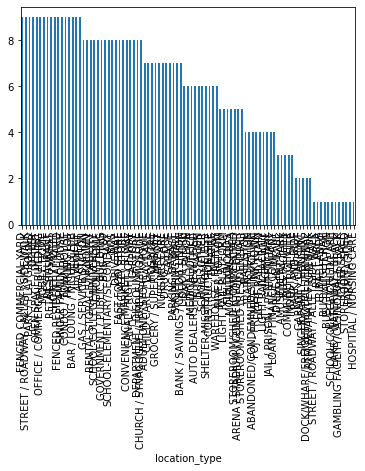

In [414]:
#single_family=crimes[(crimes.location_type=='SINGLE FAMILY HOUSE')]

# distinct types of crime by location type
dist_types = crimes.groupby(by='location_type')['crime_category'].nunique()

dist_types.sort_values(ascending=False).plot.bar()

#crimes.crime_category.count()

<AxesSubplot:>

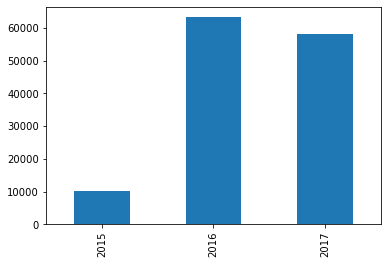

In [415]:
# let's check out the case counts by year
def get_year(x):
    if pd.isna(x)!=True:
        return x.year
    else:
        return 'Unknown'

# turn the datetime strings into datetime objects
crimes.occured_on=pd.to_datetime(crimes.occured_on)
crimes.occured_to=pd.to_datetime(crimes.occured_to)



# add a new column for the year
crimes["occured_year"]=crimes.occured_on.apply(lambda x:get_year(x))

# exclude the few that had no occured_on date
yearly_crimes = crimes[(crimes.occured_year!='Unknown')]

# show the sequential annual amounts
yearly_crimes['occured_year'].value_counts().sort_index().plot.bar()

#crimes.tail()

<AxesSubplot:xlabel='occured_year'>

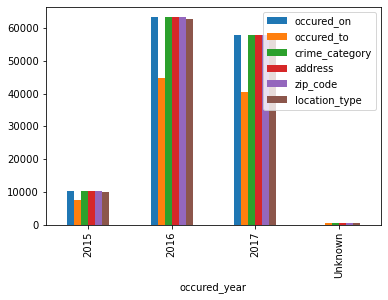

In [416]:
# this is a visual quality check that quickly shows:
#   occured_to is often missing values
#   location_type is ommitted occasionally
qual_check = crimes.groupby(by='occured_year').count()
qual_check.plot.bar()

In [486]:
url='https://raw.githubusercontent.com/rather-be-hiking/stc510-public/main/uszips.csv'
zips=pd.read_csv(url, index_col="zip")
zips
#zips.loc[int('85008'),'city']+', '+zips.loc[int('85234'),'state_id']
#city = zips.loc[[int('53081')]]
#city[0:1]

#could use population to find out % crime per capita

,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone
zip,,,,,,,,,,,,,,,,,
601,18.18005,-66.75218,Adjuntas,PR,Puerto Rico,True,NaN,17113.0,102.7,72001,Adjuntas,"{""72001"": ""99.43"", ""72141"": ""0.57""}",Adjuntas|Utuado,72001|72141,False,False,America/Puerto_Rico
602,18.36074,-67.17519,Aguada,PR,Puerto Rico,True,NaN,37751.0,476.0,72003,Aguada,"{""72003"": ""100""}",Aguada,72003,False,False,America/Puerto_Rico
603,18.45440,-67.12201,Aguadilla,PR,Puerto Rico,True,NaN,47081.0,574.9,72005,Aguadilla,"{""72005"": ""100""}",Aguadilla,72005,False,False,America/Puerto_Rico
606,18.16721,-66.93828,Maricao,PR,Puerto Rico,True,NaN,6392.0,58.3,72093,Maricao,"{""72093"": ""94.88"", ""72153"": ""3.78"", ""72121"": ""...",Maricao|Yauco|Sabana Grande,72093|72153|72121,False,False,America/Puerto_Rico
610,18.29032,-67.12244,Anasco,PR,Puerto Rico,True,NaN,26686.0,286.9,72011,Añasco,"{""72011"": ""99.45"", ""72003"": ""0.55""}",Añasco|Aguada,72011|72003,False,False,America/Puerto_Rico
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99923,55.97796,-130.03671,Hyder,AK,Alaska,True,NaN,14.0,0.3,2198,Prince of Wales-Hyder,"{""02198"": ""100""}",Prince of Wales-Hyder,02198,False,False,America/Sitka
99925,55.55796,-132.97482,Klawock,AK,Alaska,True,NaN,908.0,6.3,2198,Prince of Wales-Hyder,"{""02198"": ""100""}",Prince of Wales-Hyder,02198,False,False,America/Sitka
99926,55.12617,-131.48928,Metlakatla,AK,Alaska,True,NaN,1654.0,4.8,2198,Prince of Wales-Hyder,"{""02198"": ""100""}",Prince of Wales-Hyder,02198,False,False,America/Metlakatla
